#### Install required libraries


In [1]:
# Built-in libraries
import pandas as pd

# Scikit-learn libraries for model selection, metrics, pipeline, impute, preprocessing, compose, and ensemble
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV,  train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Other libraries
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from zoish.feature_selectors.shap_selectors import ShapFeatureSelector, ShapPlotFeatures
import logging
from zoish import logger
logger.setLevel(logging.ERROR)
from feature_engine.imputation import (
     MeanMedianImputer
    )

# Set logging level
logger.setLevel(logging.ERROR)



#### Example: Audiology (Standardized) Data Set
###### https://archive.ics.uci.edu/ml/datasets/Audiology+%28Standardized%29


#### Read data


In [2]:
urldata = "https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data"
urlname = "https://archive.ics.uci.edu/ml/machine-learning-databases/lung-cancer/lung-cancer.names"
# column names
col_names = [
    "class",
    "lymphatics",
    "block of affere",
    "bl. of lymph. c",
    "bl. of lymph. s",
    "by pass",
    "extravasates",
    "regeneration of",
    "early uptake in",
    "lym.nodes dimin",
    "lym.nodes enlar",
    "changes in lym.",
    "defect in node",
    "changes in node",
    "special forms",
    "dislocation of",
    "exclusion of no",
    "no. of nodes in",

]

data = pd.read_csv(urldata,names=col_names)
data.head()


,class,lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym.,defect in node,changes in node,special forms,dislocation of,exclusion of no,no. of nodes in
3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


#### Define labels and train-test split


In [3]:


data.loc[(data["class"] == 1) | (data["class"] == 2), "class"] = 0
data.loc[data["class"] == 3, "class"] = 1
data.loc[data["class"] == 4, "class"] = 2
data["class"] = data["class"].astype(int)

#### Train test split


In [4]:
X = data.loc[:, data.columns != "class"]
y = data.loc[:, data.columns == "class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33,  random_state=42
)

#### Defining the feature pipeline steps:
Here, we use an untuned XGBClassifier model with the ShapFeatureSelector.In the next section, we will repeat the same process but with a tuned XGBClassifier. The aim is to demonstrate that a better estimator can yield improved results when used with the ShapFeatureSelector.


In [5]:
estimator_for_feature_selector= XGBClassifier()     
estimator_for_feature_selector.fit(X_train, y_train)
shap_feature_selector = ShapFeatureSelector(model=estimator_for_feature_selector, num_features=5, cv = 5, scoring='accuracy', direction='maximum', n_iter=10, algorithm='auto')
        
# Define pre-processing for numeric columns (float and integer types)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define pre-processing for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder(handle_missing='return_nan'))])

# Combine preprocessing into one column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature Selection using ShapSelector 
feature_selection = shap_feature_selector 

# Classifier model
classifier = RandomForestClassifier(n_estimators=100)

# Create a pipeline that combines the preprocessor with a feature selection and a classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('feature_selection', feature_selection),
                           ('classifier', classifier)])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[0 0 1 2 0 0 2 1 1 1]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


#### Check performance of the Pipeline


In [6]:

print("F1 score : ")
print(f1_score(y_test, y_test_pred,average='micro'))
print("Classification report : ")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_test_pred))



F1 score : 
0.3469387755102041
Classification report : 
              precision    recall  f1-score   support

           0       0.39      0.43      0.41        21
           1       0.31      0.29      0.30        14
           2       0.31      0.29      0.30        14

    accuracy                           0.35        49
   macro avg       0.34      0.33      0.33        49
weighted avg       0.34      0.35      0.34        49

Confusion matrix : 
[[9 6 6]
 [7 4 3]
 [7 3 4]]



#### Use better estimator:
In this iteration, we will utilize the optimally tuned estimator with the ShapFeatureSelector, which is expected to yield improved results."

In [7]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()


In [8]:

# Define the XGBClassifier
xgb_clf = XGBClassifier()

# Define the parameter grid for XGBClassifier
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [ 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
}

# Define the scoring function
scoring = make_scorer(f1_score, average='micro')  # Use 'micro' average in case of multiclass target

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring=scoring, verbose=1)
grid_search.fit(X_train, y_train)
# Fit the GridSearchCV object
estimator_for_feature_selector= grid_search.best_estimator_ 
shap_feature_selector = ShapFeatureSelector(model=estimator_for_feature_selector, num_features=5, scoring='accuracy', algorithm='auto',cv = 5, n_iter=10, direction='maximum')


pipeline =Pipeline([
            # int missing values imputers
            ('floatimputer', MeanMedianImputer(
                imputation_method='mean', variables=int_cols)),
           
            ('shap_feature_selector', shap_feature_selector),
            ('classfier', RandomForestClassifier(n_estimators=100))


 ])


# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])
            

Fitting 5 folds for each of 36 candidates, totalling 180 fits


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[0 0 1 1 1 0 2 1 1 1]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


#### Performance has improved

In [9]:

print("F1 score : ")
print(f1_score(y_test, y_test_pred,average='micro'))
print("Classification report : ")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_test_pred))



F1 score : 
0.42857142857142855
Classification report : 
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        21
           1       0.27      0.29      0.28        14
           2       0.56      0.36      0.43        14

    accuracy                           0.43        49
   macro avg       0.43      0.40      0.41        49
weighted avg       0.44      0.43      0.43        49

Confusion matrix : 
[[12  8  1]
 [ 7  4  3]
 [ 6  3  5]]


#### Shap related plots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


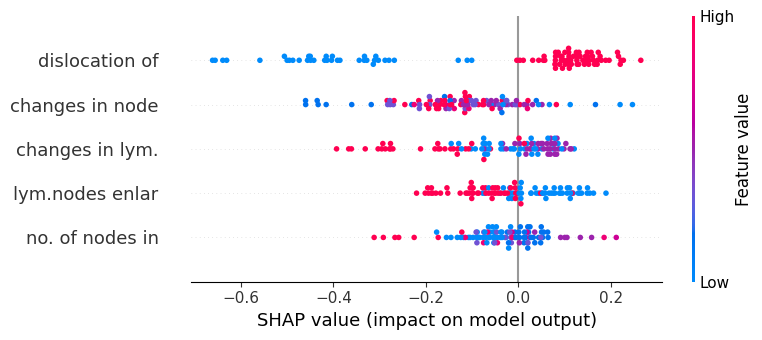

In [10]:

# Plot the feature importance
plot_factory = ShapPlotFeatures(shap_feature_selector) 
plot_factory.summary_plot()


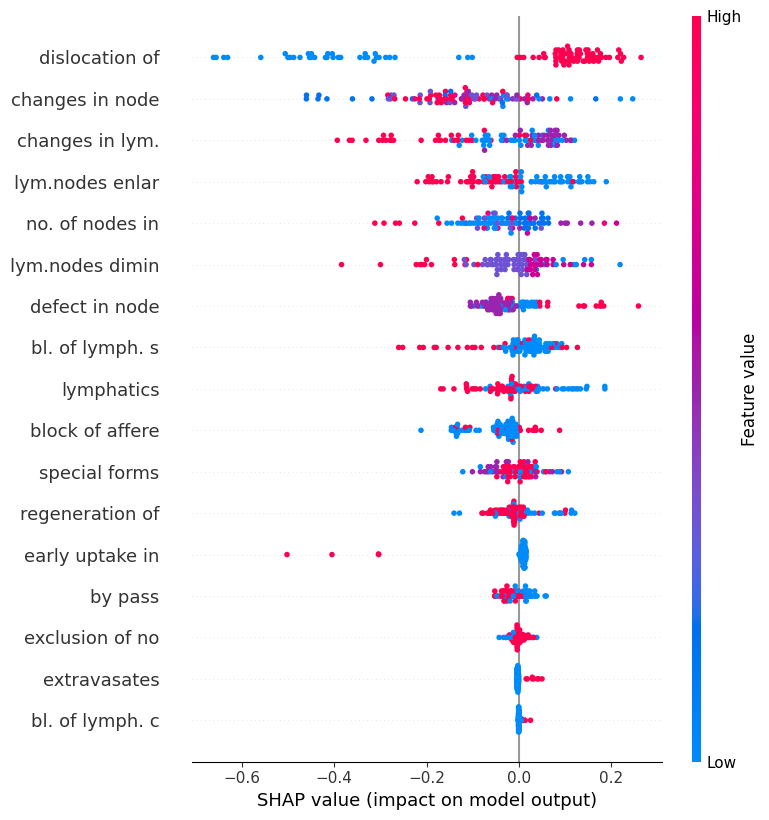

In [11]:
plot_factory.summary_plot_full()

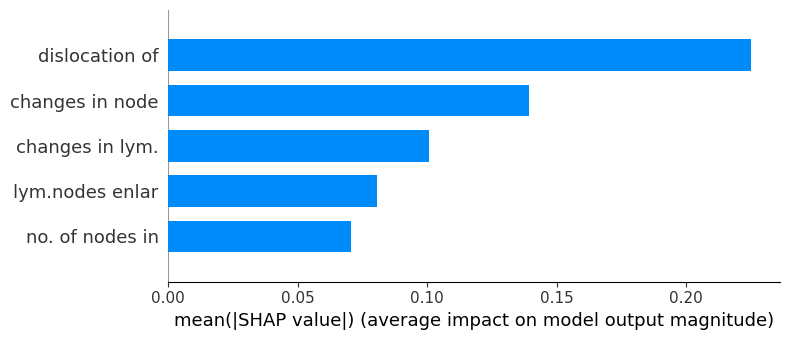

In [12]:

# Plot the feature importance
plot_factory.bar_plot()

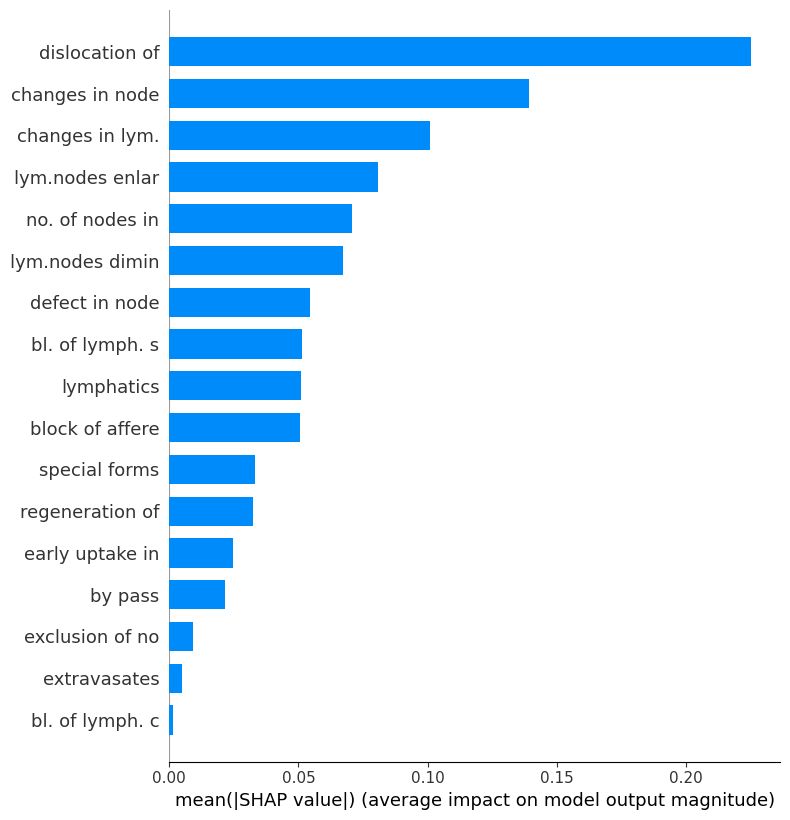

In [13]:
plot_factory.bar_plot_full()